In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import functools
import operator
import matplotlib.patches as mpatches

from sklearn.metrics import matthews_corrcoef, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Confusion Matrices

In [ ]:
def confusion_matrix_plotter(image_results, lstm_results, transformer_results, multimodal_results, x_tick_labels, y_tick_labels, color, normalize: bool=False):
    """
    Plots confusion matrix

    results: dictionary item containing key of confusion matrix (output of sklearn confusion_matrix())

    x_tick_labels: list of tick labels on x axis

    y_tick_labels: list of tick labels on y axis

    color: color selection from matplotlib cmap choices: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

    normalize: normalizes the values to show percentages instead of number of predictions
    """

    image_cm = image_results.ravel()[0]["confusion_matrix"]
    lstm_cm = lstm_results.ravel()[0]["confusion_matrix"]
    transformer_cm = transformer_results.ravel()[0]["confusion_matrix"]
    multimodal_cm = multimodal_results.ravel()[0]["confusion_matrix"]
    
    if normalize == True:
        image_cm = image_cm.astype('float') / image_cm.sum(axis=1)[:, np.newaxis]
        lstm_cm = lstm_cm.astype('float') / lstm_cm.sum(axis=1)[:, np.newaxis]
        transformer_cm = transformer_cm.astype('float') / transformer_cm.sum(axis=1)[:, np.newaxis]
        multimodal_cm = multimodal_cm.astype('float') / multimodal_cm.sum(axis=1)[:, np.newaxis]


    image_cm = pd.DataFrame(image_cm)
    lstm_cm = pd.DataFrame(lstm_cm)
    transformer_cm = pd.DataFrame(transformer_cm)
    multimodal_cm = pd.DataFrame(multimodal_cm)

    fig = plt.figure(figsize=(16, 12))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.40, hspace=.60)
    
    plt.rc('axes', titlesize=18) 
    plt.rc('axes', labelsize=14)  
    plt.rc('xtick', labelsize=12)   
    plt.rc('ytick', labelsize=12)       

    plt.subplot(2, 2, 1)
    g1 = sns.heatmap(image_cm, annot=True, fmt='g', cmap=color)
    g1.set_xlabel('Predicted Label')
    g1.set_ylabel('True Label', rotation=0) 
    g1.xaxis.set_ticklabels(x_tick_labels, rotation=45) 
    g1.yaxis.set_ticklabels(y_tick_labels, rotation=0) 
    g1.set_title('Image')

    plt.subplot(2, 2, 2)
    g2 = sns.heatmap(lstm_cm, annot=True, fmt='g', cmap=color)
    g2.set_xlabel('Predicted Label')
    g2.set_ylabel('True Label', rotation=0) 
    g2.xaxis.set_ticklabels(x_tick_labels, rotation=45) 
    g2.yaxis.set_ticklabels(y_tick_labels, rotation=0) 
    g2.set_title('LSTM')

    plt.subplot(2, 2, 3)
    g3 = sns.heatmap(transformer_cm, annot=True, fmt='g', cmap=color)
    g3.set_xlabel('Predicted Label')
    g3.set_ylabel('True Label', rotation=0) 
    g3.xaxis.set_ticklabels(x_tick_labels, rotation=45) 
    g3.yaxis.set_ticklabels(y_tick_labels, rotation=0) 
    g3.set_title('Transformer')

    plt.subplot(2, 2, 4)
    g4 = sns.heatmap(multimodal_cm, annot=True, fmt='g', cmap=color)
    g4.set_xlabel('Predicted Label')
    g4.set_ylabel('True Label', rotation=0) 
    g4.xaxis.set_ticklabels(x_tick_labels, rotation=45) 
    g4.yaxis.set_ticklabels(y_tick_labels, rotation=0) 
    g4.set_title('Multimodal')

    plt.savefig("combined_dw_cm.png",bbox_inches='tight')

    return plt.show()

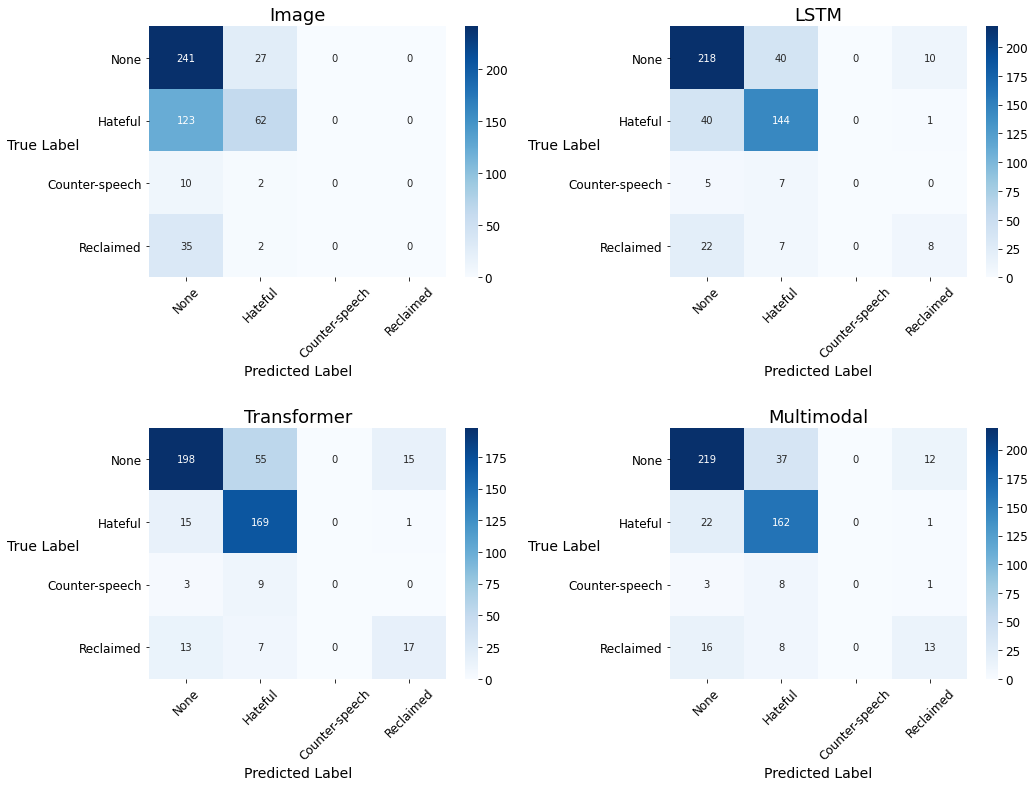

In [ ]:
image_results = np.load("/content/drive/My Drive/Dog_Whistle_Code/Fine_Tuned_Models/Image/Xception/Xception_dogwhistle_test_results_multimodal.npy", allow_pickle=True)
lstm_results = np.load("/content/drive/My Drive/Dog_Whistle_Code/Fine_Tuned_Models/Text/LSTM/LSTM_dogwhistle_test_results.npy", allow_pickle=True)
transformer_results = np.load("/content/drive/My Drive/Dog_Whistle_Code/Fine_Tuned_Models/Text/RoBERTa/RoBERTa_dogwhistle_test_results.npy", allow_pickle=True)
multimodal_results = np.load("/content/drive/My Drive/Dog_Whistle_Code/Fine_Tuned_Models/Multimodal/MMBT/results.npy", allow_pickle=True)

X_TICK_LABELS = ["None", "Hateful", "Counter-speech", "Reclaimed"]
Y_TICK_LABELS = ["None", "Hateful", "Counter-speech", "Reclaimed"]
COLOR = "Blues"

confusion_matrix_plotter(image_results, lstm_results, transformer_results, multimodal_results, X_TICK_LABELS, Y_TICK_LABELS, COLOR)


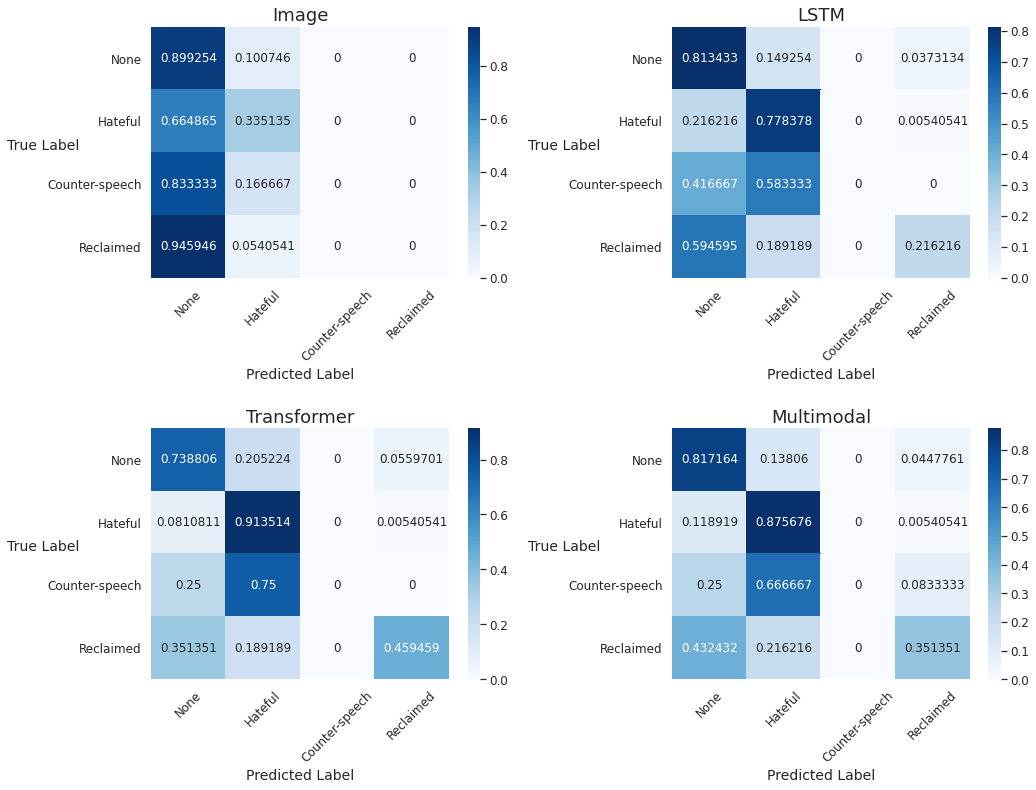

In [ ]:
# Normalized Confusion Matrix
confusion_matrix_plotter(image_results, lstm_results, transformer_results, multimodal_results, X_TICK_LABELS, Y_TICK_LABELS, COLOR, normalize=True)

## Error Analyses

In [ ]:
# Load test dataset
test1 = pd.read_csv("/content/drive/My Drive/Dog_Whistle_Code/Data/Test/dog_whistle_test.csv", encoding='utf-8') #lists are saved as strings
total_data = np.load("/content/drive/My Drive/Dog_Whistle_Code/Data/final_ground_truth.pkl", allow_pickle=True) 
total_data["keep"] = total_data["image_number"].map(lambda x: int(x) in test1["image_number"].values.tolist())
test = total_data[total_data["keep"] == True].reset_index()

# Load predictions 
transformer_predictions = pd.read_csv("/content/drive/My Drive/Dog_Whistle_Code/Fine_Tuned_Models/Text/RoBERTa/RoBERTa_dogwhistle_predictions.csv")
transformer_predictions["image_number"] = test1["image_number"]
transformer_predictions["Transformer_Predictions"] = transformer_predictions["Predictions"]

lstm_predictions = pd.read_csv("/content/drive/My Drive/Dog_Whistle_Code/Fine_Tuned_Models/Text/LSTM/LSTM_dogwhistle_predictions.csv")
lstm_predictions["LSTM_Predictions"] = lstm_predictions["Predictions"]
lstm_predictions["image_number"] = lstm_predictions["image_number"].map(lambda x: int(x))

image_predictions = pd.read_csv("/content/drive/My Drive/Dog_Whistle_Code/Fine_Tuned_Models/Image/Xception/Xception_dogwhistle_predictions.csv")
image_predictions["Labels"] = image_predictions["Multimodal Labels"] 
image_predictions["Image_Predictions"] = image_predictions["Predictions_multimodal"] #.map(lambda x: x[10])
image_predictions["Image_Predictions"] = image_predictions["Image_Predictions"].map(lambda x: int(x))  
image_predictions = image_predictions[["image_number", "Labels", "Image_Predictions"]]

multimodal_predictions = pd.read_csv("/content/drive/My Drive/Dog_Whistle_Code/Fine_Tuned_Models/Multimodal/MMBT/predictions.csv")
multimodal_predictions["image_number"] = test1["image_number"]
multimodal_predictions["Multimodal_Predictions"] = multimodal_predictions["Predictions"]

# Combine datasets
combined_preds = test1[["image_number", "Primary_numeric_gt"]].merge(image_predictions[["Image_Predictions", "image_number"]], on="image_number").merge(lstm_predictions[["LSTM_Predictions", "image_number"]], on="image_number").merge(transformer_predictions[["Transformer_Predictions", "image_number"]], on="image_number").merge(multimodal_predictions[["Multimodal_Predictions", "image_number"]],on="image_number")
combined_preds = combined_preds.rename(columns={"Primary_numeric_gt": "Labels"})

# Add column label info
to_merge = test[["image_number", "Strategies_numeric_gt", "Primary_numeric_expert_is_ambiguous", "Target_numeric", "Strength_numeric"]]
to_merge["image_number"] = to_merge["image_number"].map(lambda x: int(x))
combined_preds = combined_preds.merge(to_merge, on="image_number")
combined_preds = combined_preds.rename(columns={"Strategies_numeric_gt": "is_Dog_Whistle", "Primary_numeric_expert_is_ambiguous": "is_Ambiguous", "Target_numeric": "Target", "Strength_numeric": "Strength"})

combined_preds.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,image_number,Labels,Image_Predictions,LSTM_Predictions,Transformer_Predictions,Multimodal_Predictions,is_Dog_Whistle,is_Ambiguous,Target,Strength
0,1108892807018758144,0,0,0,3,3,0,0,"[[0], [0]]","[0, 0]"
1,1115276435432853504,0,0,0,0,0,0,0,"[[0], [0]]","[0, 0]"
2,1054560047202742272,1,0,0,1,1,2,0,"[[6], [6]]","[1, 1]"
3,1024252637045239808,0,0,0,0,0,0,0,"[[0], [0]]","[0, 0]"
4,1053894921961304064,1,0,0,1,1,1,1,"[[13], [13]]","[2, 1]"


In [ ]:
def metrics(labels, preds, argmax_needed: bool = False):
    """
    Returns the Matthew's correlation coefficient, accuracy rate, true positive rate, true negative rate, false positive rate, false negative rate, precission, recall, and f1 score
    
    labels: list of correct labels

    pred: list of model predictions
    """
    labels = labels
    preds = preds

    if argmax_needed == True:
        preds = np.argmax(preds, axis=1).flatten()

    mcc = matthews_corrcoef(labels, preds)
    acc = accuracy_score(labels, preds)
    cm = confusion_matrix(labels, preds)

    f1 = f1_score(labels, preds, average= "weighted")
    precision = precision_score(labels, preds, average= "weighted")
    recall = recall_score(labels, preds, average= "weighted")

    results = {
        "mcc": mcc,
        "acc": acc,
        "confusion_matrix": cm,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }
    
    return results


def accuracy_analyzer(dataset_dict, model_dict, reported_metric):
    """ Prints metrics computed for various subsets of the predictions dataset

    dataset_dict: Dictionary whose values are dataframe slices by secondary labels of the prediction dataset and keys are descriptions

    model_dict: Dictionary whose values are the column containing the predictions and keys are the name of the model

    reported_metric: Which metric to show
    """
    
    error_dict = {}
    
    for i in dataset_dict:
        data_dict = {}
        for j in model_dict:
            labels = dataset_dict[i]["Labels"]
            preds = dataset_dict[i][model_dict[j]]
            category_count = len(labels)

            temp_metrics = metrics(labels, preds)

            data_dict[j] = [temp_metrics[reported_metric], category_count]

        error_dict[i] = data_dict

    return error_dict

In [ ]:
# Sanity check
accuracy_analyzer({"All": combined_preds}, {"Image": "Image_Predictions", "LSTM": "LSTM_Predictions", "Transformer": "Transformer_Predictions", "Multimodal": "Multimodal_Predictions"}, "f1")

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'All': {'Image': [0.5444710854042994, 502],
  'LSTM': [0.7190877940746235, 502],
  'Multimodal': [0.7713136091995654, 502],
  'Transformer': [0.7542590909883958, 502]}}

### Strategy

In [ ]:
# Slice dataset by strategy
none_preds = combined_preds[combined_preds["is_Dog_Whistle"] == 0].reset_index()
explicit_preds = combined_preds[combined_preds["is_Dog_Whistle"] == 1].reset_index()
dw_preds = combined_preds[combined_preds["is_Dog_Whistle"] == 2].reset_index()

# Compute Metrics
strategy_accuracy_dict = accuracy_analyzer({"None": none_preds, "Explicit": explicit_preds, "Dog Whistle": dw_preds}, {"Image": "Image_Predictions", "LSTM": "LSTM_Predictions", "Transformer": "Transformer_Predictions", "Multimodal": "Multimodal_Predictions"}, "acc")

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [ ]:
strategy_accuracy_dict

{'Dog Whistle': {'Image': [0.3697478991596639, 119],
  'LSTM': [0.7983193277310925, 119],
  'Multimodal': [0.8991596638655462, 119],
  'Transformer': [0.9411764705882353, 119]},
 'Explicit': {'Image': [0.2727272727272727, 66],
  'LSTM': [0.7424242424242424, 66],
  'Multimodal': [0.8333333333333334, 66],
  'Transformer': [0.8636363636363636, 66]},
 'None': {'Image': [0.7602523659305994, 317],
  'LSTM': [0.7129337539432177, 317],
  'Multimodal': [0.7318611987381703, 317],
  'Transformer': [0.6782334384858044, 317]}}

### Target and Strength

In [ ]:
# Slice dataset by Target

def target_identifier(input_df, hate_only: bool=False):
    """ Returns list of dataframes sliced by target

    input_df: dataframe object containing target labels

    hate_only (bool): Flag determining if only data labeled as hateful should be sliced by target. Defaulted to True.
    """

    df = input_df.copy()

    if hate_only == True:
        df = df[df["Labels"] == 1] # Only tweets that are hateful
    else:
        df = df[df["Labels"] != 0] # Only tweets that are not "None" should have targets

    df["Target"] = df["Target"].map(lambda x: functools.reduce(operator.iconcat, x, []))
    df["Target"] = df["Target"].map(lambda x: new_map(x))

    df_list = []

    for i in range(1, 10):
        new_target_list = []
        for j in df["Target"]:
            if i in j:
                new_target_list.append(i)
            else:
                new_target_list.append(100) 

        df["New_Target"] = new_target_list
        temp_df = df[df["New_Target"] == i].reset_index()
        df_list.append(temp_df)

    return df_list

def new_map(input_list):
    """
    input_list: List of numeric target labels 
    """
    new_target_mapping = {0: 0,
                          1: 1,
                          2: 9, 
                          3: 9,
                          4: 2,
                          5: 2,
                          6: 3,
                          7: 7,
                          8: 9, 
                          9: 4,
                          10: 4,
                          15: 9,
                          11: 5,
                          12: 6,
                          13: 8,
                          14: 9}
    new_list = []

    for i in input_list:
        new_list.append(new_target_mapping[i])

    return new_list

ability, conservatives, ethnicity, liberals, race, religion, gender, sexual_orientation, other = [i for i in target_identifier(combined_preds)]

# Compute metrics
target_f1_dict = accuracy_analyzer({"Ability": ability, "Conservatives": conservatives, "Ethnicity": ethnicity, "Liberals": liberals, "Race": race, "Religion": religion, "Gender": gender, "Sexual Orientation": sexual_orientation, "Other": other}, 
               {"Image": "Image_Predictions", "LSTM": "LSTM_Predictions", "Transformer": "Transformer_Predictions", "Multimodal": "Multimodal_Predictions"}, 
               "f1")

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [ ]:
target_f1_dict

{'Ability': {'Image': [0.34449760765550236, 19],
  'LSTM': [0.8661654135338345, 19],
  'Multimodal': [0.9473684210526315, 19],
  'Transformer': [0.8947368421052632, 19]},
 'Conservatives': {'Image': [0.5, 6],
  'LSTM': [0.9090909090909091, 6],
  'Multimodal': [0.8000000000000002, 6],
  'Transformer': [1.0, 6]},
 'Ethnicity': {'Image': [0.6120218579234974, 61],
  'LSTM': [0.749130650769995, 61],
  'Multimodal': [0.864381520119225, 61],
  'Transformer': [0.8659250585480095, 61]},
 'Gender': {'Image': [0.5259740259740261, 22],
  'LSTM': [0.6334310850439883, 22],
  'Multimodal': [0.6737967914438503, 22],
  'Transformer': [0.6900826446280991, 22]},
 'Liberals': {'Image': [0.46153846153846156, 78],
  'LSTM': [0.8598524762908324, 78],
  'Multimodal': [0.8665620094191524, 78],
  'Transformer': [0.8861538461538462, 78]},
 'Other': {'Image': [0.3846153846153846, 21],
  'LSTM': [0.923076923076923, 21],
  'Multimodal': [0.9500000000000002, 21],
  'Transformer': [0.975609756097561, 21]},
 'Race': {

In [ ]:
# Prepare Target data for plot
x_image_target = [1, 1, 1, 1, 1, 1, 1, 1, 1]
y_image_target  = [target_f1_dict[i]["Image"][0] for i in target_f1_dict]
x_lstm_target  = [2, 2, 2, 2, 2, 2, 2, 2, 2]
y_lstm_target  = [target_f1_dict[i]["LSTM"][0]  for i in target_f1_dict]
x_transformer_target  = [3, 3, 3, 3, 3, 3, 3, 3, 3]
y_transformer_target  = [target_f1_dict[i]["Transformer"][0] for i in target_f1_dict]
x_mulitmodal_target  = [4, 4, 4, 4, 4, 4, 4, 4, 4]
y_multimodal_target  = [target_f1_dict[i]["Multimodal"][0] for i in target_f1_dict]


In [ ]:
# Slice dataset by Strength
def strength_indentifier(input_df):
    """ list of dataframes sliced by strength

    input_df: dataframe object containing target labels
    """

    df = input_df.copy()
    df = df[df["Labels"] == 1]

    # new_strength = []

    # for i in df["Strength"]:
    #     if i[0] == i[1]:
    #         new_strength.append(i[0])
    #     else:
    #         new_strength.append(100)

    # df["Strength_Ambiguous"] = new_strength
    # df = df[df["Strength_Ambiguous"] != 100].reset_index()
    
    df_list = []

    for i in range(1, 4):
        new_strength_list = []
        for j in df["Strength"]:
            if i in j:
                new_strength_list.append(i)
            else:
                new_strength_list.append(100)

        df["New_Strength"] = new_strength_list
        temp_df = df[df["New_Strength"] == i].reset_index()
        df_list.append(temp_df)


    return df_list

animosity, derogation, extreme = [i for i in strength_indentifier(combined_preds)]

# Compute metrics
strength_accuracy_dict = accuracy_analyzer({"Animosity": animosity, "Derogation": derogation, "Extreme": extreme}, {"Image": "Image_Predictions", "LSTM": "LSTM_Predictions", "Transformer": "Transformer_Predictions", "Multimodal": "Multimodal_Predictions"}, "acc")


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
strength_accuracy_dict

{'Animosity': {'Image': [0.384, 125],
  'LSTM': [0.808, 125],
  'Multimodal': [0.896, 125],
  'Transformer': [0.944, 125]},
 'Derogation': {'Image': [0.3464566929133858, 127],
  'LSTM': [0.7716535433070866, 127],
  'Multimodal': [0.8582677165354331, 127],
  'Transformer': [0.905511811023622, 127]},
 'Extreme': {'Image': [0.3333333333333333, 9],
  'LSTM': [0.8888888888888888, 9],
  'Multimodal': [1.0, 9],
  'Transformer': [1.0, 9]}}

In [ ]:
# Prepare Strength data for plot
x_image_strength = [1, 1, 1]
y_image_strength  = [strength_accuracy_dict[i]["Image"][0] for i in strength_accuracy_dict]
x_lstm_strength  = [2, 2, 2]
y_lstm_strength  = [strength_accuracy_dict[i]["LSTM"][0]  for i in strength_accuracy_dict]
x_transformer_strength  = [3, 3, 3]
y_transformer_strength  = [strength_accuracy_dict[i]["Transformer"][0] for i in strength_accuracy_dict]
x_mulitmodal_strength  = [4, 4, 4]
y_multimodal_strength  = [strength_accuracy_dict[i]["Multimodal"][0] for i in strength_accuracy_dict]

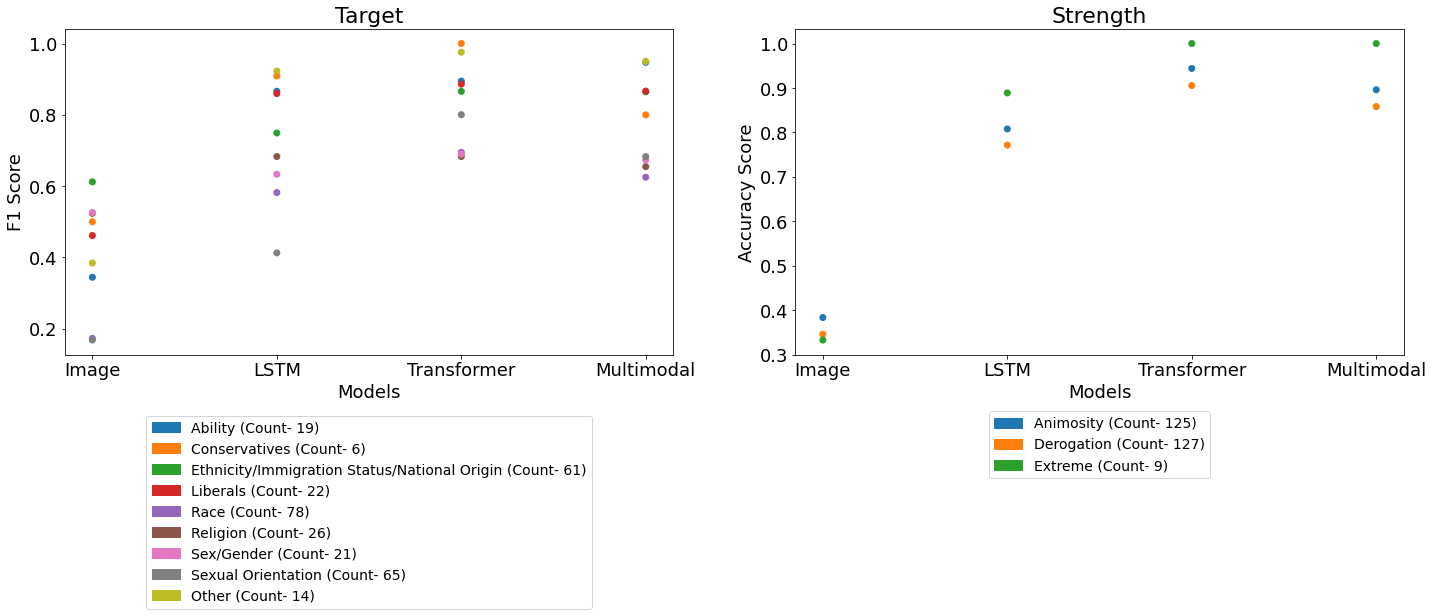

In [ ]:
plt.rcParams["figure.figsize"] = (24,6)
plt.rcParams.update({'font.size': 14})
plt.rc('axes', titlesize=22) 
plt.rc('axes', labelsize=18)  
plt.rc('xtick', labelsize=18)   
plt.rc('ytick', labelsize=18) 
fig, (ax1, ax2) = plt.subplots(1, 2)    


# Plot model accuracy by target
ax1.scatter(x_image_target, y_image_target, c=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8'])
ax1.scatter(x_lstm_target, y_lstm_target, c=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8'])
ax1.scatter(x_transformer_target, y_transformer_target, c=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8'])
ax1.scatter(x_mulitmodal_target, y_multimodal_target, c=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8'])

ax1.set_xticks([1, 2, 3, 4])
ax1.set_xticklabels(["Image", "LSTM", "Transformer", "Multimodal"])
patches = [mpatches.Patch(color='C0', label='Ability (Count- 19)'),
           mpatches.Patch(color='C1', label='Conservatives (Count- 6)'),
           mpatches.Patch(color='C2', label='Ethnicity/Immigration Status/National Origin (Count- 61)'),
           mpatches.Patch(color='C3', label='Liberals (Count- 22)'),
           mpatches.Patch(color='C4', label='Race (Count- 78)'),
           mpatches.Patch(color='C5', label='Religion (Count- 26)'),
           mpatches.Patch(color='C6', label='Sex/Gender (Count- 21)'),
           mpatches.Patch(color='C7', label='Sexual Orientation (Count- 65)'),
           mpatches.Patch(color='C8', label='Other (Count- 14)')]
ax1.legend(handles=patches, loc='lower center', bbox_to_anchor=(.5, -.8, 0, 0))
ax1.set_ylabel('F1 Score', rotation = 90)
ax1.set_xlabel("Models")
ax1.set_title("Target")


# Plot model accuracy by strength
ax2.scatter(x_image_strength, y_image_strength, c=['C0', 'C1', 'C2'])
ax2.scatter(x_lstm_strength, y_lstm_strength, c=['C0', 'C1', 'C2'])
ax2.scatter(x_transformer_strength, y_transformer_strength, c=['C0', 'C1', 'C2'])
ax2.scatter(x_mulitmodal_strength, y_multimodal_strength, c=['C0', 'C1', 'C2'])

ax2.set_xticks([1, 2, 3, 4])
ax2.set_xticklabels(["Image", "LSTM", "Transformer", "Multimodal"])
patches = [mpatches.Patch(color='C0', label='Animosity (Count- 125)'),
           mpatches.Patch(color='C1', label='Derogation (Count- 127)'),
           mpatches.Patch(color='C2', label='Extreme (Count- 9)')]
ax2.legend(handles=patches, loc='lower center', bbox_to_anchor=(.5, -.4, 0, 0))
ax2.set_ylabel('Accuracy Score', rotation = 90)
ax2.set_xlabel("Models")
ax2.set_title("Strength")

plt.savefig("target_strength_error_analysis.png",bbox_inches='tight')
plt.show()

### Ambiguity

In [ ]:
# Slice dataset by ambiguity
unambiguous = combined_preds[combined_preds["is_Ambiguous"] == 0].reset_index()
ambiguous  = combined_preds[combined_preds["is_Ambiguous"] == 1].reset_index()

# Compute metrics
ambiguity_f1_dict = accuracy_analyzer({"Unambiguous": unambiguous, "Ambiguous": ambiguous}, {"Image": "Image_Predictions", "LSTM": "LSTM_Predictions", "Transformer": "Transformer_Predictions", "Multimodal": "Multimodal_Predictions"}, "f1")
ambiguity_f1_dict

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Ambiguous': {'Image': [0.39805601109646566, 272],
  'LSTM': [0.6430764162128133, 272],
  'Multimodal': [0.691898729188645, 272],
  'Transformer': [0.6818240174857823, 272]},
 'Unambiguous': {'Image': [0.7581711155146288, 230],
  'LSTM': [0.827282763131348, 230],
  'Multimodal': [0.8750180891646713, 230],
  'Transformer': [0.8453704929771568, 230]}}

## Error Analyses with Ambiguity Split

### Strategy

In [ ]:
# Slice unambiguous dataset by strategy
none_preds = unambiguous[unambiguous["is_Dog_Whistle"] == 0].reset_index()
explicit_preds = unambiguous[unambiguous["is_Dog_Whistle"] == 1].reset_index()
dw_preds = unambiguous[unambiguous["is_Dog_Whistle"] == 2].reset_index()

# Compute Metrics
strategy_accuracy_dict = accuracy_analyzer({"None": none_preds, "Explicit": explicit_preds, "Dog Whistle": dw_preds}, {"Image": "Image_Predictions", "LSTM": "LSTM_Predictions", "Transformer": "Transformer_Predictions", "Multimodal": "Multimodal_Predictions"}, "acc")

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [ ]:
strategy_accuracy_dict

{'Dog Whistle': {'Image': [0.47058823529411764, 34],
  'LSTM': [0.8235294117647058, 34],
  'Multimodal': [0.9705882352941176, 34],
  'Transformer': [0.9705882352941176, 34]},
 'Explicit': {'Image': [0.3333333333333333, 9],
  'LSTM': [1.0, 9],
  'Multimodal': [1.0, 9],
  'Transformer': [1.0, 9]},
 'None': {'Image': [0.8663101604278075, 187],
  'LSTM': [0.8181818181818182, 187],
  'Multimodal': [0.8449197860962567, 187],
  'Transformer': [0.8021390374331551, 187]}}

In [ ]:
# Slice ambiguous dataset by strategy
none_preds = ambiguous[ambiguous["is_Dog_Whistle"] == 0].reset_index()
explicit_preds = ambiguous[ambiguous["is_Dog_Whistle"] == 1].reset_index()
dw_preds = ambiguous[ambiguous["is_Dog_Whistle"] == 2].reset_index()

# Compute Metrics
strategy_accuracy_dict = accuracy_analyzer({"None": none_preds, "Explicit": explicit_preds, "Dog Whistle": dw_preds}, {"Image": "Image_Predictions", "LSTM": "LSTM_Predictions", "Transformer": "Transformer_Predictions", "Multimodal": "Multimodal_Predictions"}, "acc")

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [ ]:
strategy_accuracy_dict

{'Dog Whistle': {'Image': [0.32941176470588235, 85],
  'LSTM': [0.788235294117647, 85],
  'Multimodal': [0.8705882352941177, 85],
  'Transformer': [0.9294117647058824, 85]},
 'Explicit': {'Image': [0.2631578947368421, 57],
  'LSTM': [0.7017543859649122, 57],
  'Multimodal': [0.8070175438596491, 57],
  'Transformer': [0.8421052631578947, 57]},
 'None': {'Image': [0.6076923076923076, 130],
  'LSTM': [0.5615384615384615, 130],
  'Multimodal': [0.5692307692307692, 130],
  'Transformer': [0.5, 130]}}

### Strength and Target

In [ ]:
# Slice dataset by Strength- only unambiguous

def strength_indentifier(input_df):
    """ list of dataframes sliced by strength

    input_df: dataframe object containing target labels
    """

    df = input_df.copy()
    df = df[df["Labels"] == 1]

    new_strength = []

    for i in df["Strength"]:
        if i[0] == i[1]:
            new_strength.append(i[0])
        else:
            new_strength.append(100)

    df["Strength_Ambiguous"] = new_strength
    df = df[df["Strength_Ambiguous"] != 100].reset_index()
    
    df_list = []

    for i in range(1, 4):
        new_strength_list = []
        for j in df["Strength"]:
            if i in j:
                new_strength_list.append(i)
            else:
                new_strength_list.append(100)

        df["New_Strength"] = new_strength_list
        temp_df = df[df["New_Strength"] == i].reset_index()
        df_list.append(temp_df)


    return df_list

animosity, derogation, extreme = [i for i in strength_indentifier(combined_preds)]

# Compute metrics
strength_accuracy_dict = accuracy_analyzer({"Animosity": animosity, "Derogation": derogation, "Extreme": extreme}, {"Image": "Image_Predictions", "LSTM": "LSTM_Predictions", "Transformer": "Transformer_Predictions", "Multimodal": "Multimodal_Predictions"}, "acc")


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
strength_accuracy_dict

{'Animosity': {'Image': [0.2903225806451613, 31],
  'LSTM': [0.8064516129032258, 31],
  'Multimodal': [0.9354838709677419, 31],
  'Transformer': [0.967741935483871, 31]},
 'Derogation': {'Image': [0.30434782608695654, 23],
  'LSTM': [0.8260869565217391, 23],
  'Multimodal': [0.782608695652174, 23],
  'Transformer': [0.8695652173913043, 23]},
 'Extreme': {'Image': [nan, 0],
  'LSTM': [nan, 0],
  'Multimodal': [nan, 0],
  'Transformer': [nan, 0]}}

In [ ]:
# Prepare Strength data for plot
x_image_strength = [1, 1, 1]
y_image_strength  = [strength_accuracy_dict[i]["Image"][0] for i in strength_accuracy_dict]
x_lstm_strength  = [2, 2, 2]
y_lstm_strength  = [strength_accuracy_dict[i]["LSTM"][0]  for i in strength_accuracy_dict]
x_transformer_strength  = [3, 3, 3]
y_transformer_strength  = [strength_accuracy_dict[i]["Transformer"][0] for i in strength_accuracy_dict]
x_mulitmodal_strength  = [4, 4, 4]
y_multimodal_strength  = [strength_accuracy_dict[i]["Multimodal"][0] for i in strength_accuracy_dict]

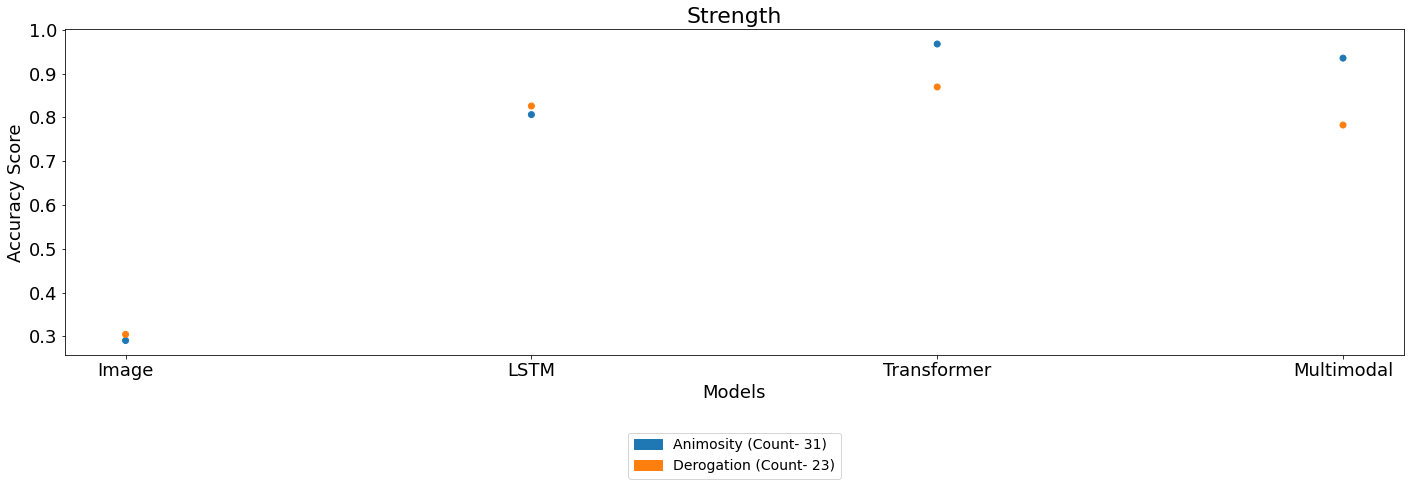

In [ ]:
plt.rcParams["figure.figsize"] = (24,6)
plt.rcParams.update({'font.size': 14})
plt.rc('axes', titlesize=22) 
plt.rc('axes', labelsize=18)  
plt.rc('xtick', labelsize=18)   
plt.rc('ytick', labelsize=18) 
fig, (ax1) = plt.subplots(1, 1)   

# Plot model accuracy by strength- unambiguous
ax1.scatter(x_image_strength, y_image_strength, c=['C0', 'C1', 'C2'])
ax1.scatter(x_lstm_strength, y_lstm_strength, c=['C0', 'C1', 'C2'])
ax1.scatter(x_transformer_strength, y_transformer_strength, c=['C0', 'C1', 'C2'])
ax1.scatter(x_mulitmodal_strength, y_multimodal_strength, c=['C0', 'C1', 'C2'])

ax1.set_xticks([1, 2, 3, 4])
ax1.set_xticklabels(["Image", "LSTM", "Transformer", "Multimodal"])
patches = [mpatches.Patch(color='C0', label='Animosity (Count- 31)'),
           mpatches.Patch(color='C1', label='Derogation (Count- 23)')]
ax1.legend(handles=patches, loc='lower center', bbox_to_anchor=(.5, -.4, 0, 0))
ax1.set_ylabel('Accuracy Score', rotation = 90)
ax1.set_xlabel("Models")
ax1.set_title("Strength")

#plt.savefig("target_strength_error_analysis.png",bbox_inches='tight')
plt.show()

## Performance and Dataset Size (LSTM vs Transformer)

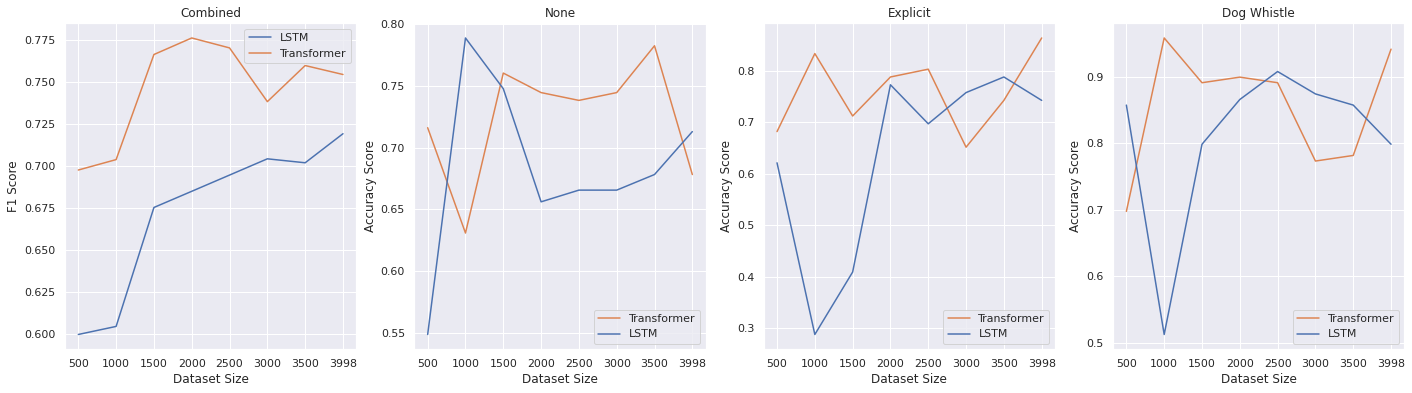

In [ ]:
# combined one is F1, rest are accuracy
LSTM_datasize = [0.5998443165746492, 0.6046323545300436, 0.67528100025809, 0.6848873593680083, 0.6945220761500359, 0.7041738637317109, 0.7018248108483498, 0.7190877940746235]
LSTM_datasize_none = [0.5488958990536278, 0.7886435331230284, 0.7476340694006309, 0.6561514195583596, 0.6656151419558359, 0.6656151419558359, 0.6782334384858044, 0.7129337539432177]
LSTM_datasize_explicit = [0.6212121212121212, 0.2878787878787879, 0.4090909090909091, 0.7727272727272727, 0.696969696969697, 0.7575757575757576, 0.7878787878787878, 0.7424242424242424]
LSTM_datasize_dw = [0.8571428571428571, 0.5126050420168067, 0.7983193277310925, 0.865546218487395, 0.907563025210084, 0.8739495798319328, 0.8571428571428571, 0.7983193277310925]

Transformer_datasize = [0.6975216089880106, 0.7037145535505039, 0.7661296306624737, 0.7759578641261214, 0.7700496774318791, 0.7381432039564217, 0.7595830180882215, 0.7542590909883958]
Transformer_datasize_none = [0.7160883280757098, 0.6309148264984227, 0.7602523659305994, 0.7444794952681388, 0.7381703470031545, 0.7444794952681388, 0.7823343848580442, 0.6782334384858044]
Transformer_datasize_explicit = [0.6818181818181818, 0.8333333333333334, 0.7121212121212122, 0.7878787878787878, 0.803030303030303, 0.6515151515151515, 0.7424242424242424, 0.8636363636363636]
Transformer_datasize_dw = [0.6974789915966386, 0.957983193277311, 0.8907563025210085, 0.8991596638655462, 0.8907563025210085, 0.773109243697479, 0.7815126050420168, 0.9411764705882353]

#Create Plot
sns.set(style='darkgrid')
plt.rcParams["figure.figsize"] = (24,6)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)

ax1.plot(LSTM_datasize, 'C0', label="LSTM")
ax1.plot(Transformer_datasize, 'C1', label="Transformer")
ax1.set_xlabel('Dataset Size')
ax1.xaxis.set_ticklabels([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 3998]) 
ax1.set_ylabel('F1 Score', rotation=90)
ax1.set_title("Combined")
ax1.legend()

ax2.plot(Transformer_datasize_none, 'C1', label="Transformer")
ax2.plot(LSTM_datasize_none, 'C0', label="LSTM")
ax2.xaxis.set_ticklabels([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 3998]) 
ax2.set_xlabel('Dataset Size')
ax2.set_ylabel('Accuracy Score', rotation=90)
ax2.set_title("None")
ax2.legend()

ax3.plot(Transformer_datasize_explicit, 'C1', label="Transformer")
ax3.plot(LSTM_datasize_explicit, 'C0', label="LSTM")
ax3.xaxis.set_ticklabels([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 3998]) 
ax3.set_xlabel('Dataset Size')
ax3.set_ylabel('Accuracy Score', rotation=90)
ax3.set_title("Explicit")
ax3.legend()

ax4.plot(Transformer_datasize_dw, 'C1', label="Transformer")
ax4.plot(LSTM_datasize_dw, 'C0', label="LSTM")
ax4.xaxis.set_ticklabels([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 3998]) 
ax4.set_xlabel('Dataset Size')
ax4.set_ylabel('Accuracy Score', rotation=90)
ax4.set_title("Dog Whistle")
ax4.legend()

#plt.savefig("dogwhistle_train_plot.png",bbox_inches='tight')

plt.show()



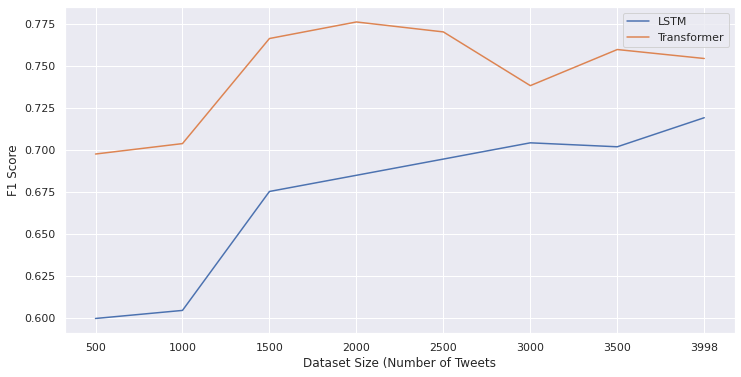

In [ ]:
# Just combined

#Create Plot
sns.set(style='darkgrid')
plt.rcParams["figure.figsize"] = (12,6)
fig, (ax1) = plt.subplots(1, 1)

ax1.plot(LSTM_datasize, 'C0', label="LSTM")
ax1.plot(Transformer_datasize, 'C1', label="Transformer")
ax1.set_xlabel('Dataset Size (Number of Tweets')
ax1.xaxis.set_ticklabels([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 3998]) 
ax1.set_ylabel('F1 Score', rotation=90)
ax1.legend()


plt.savefig("dataset_size_performance.png",bbox_inches='tight')

plt.show()

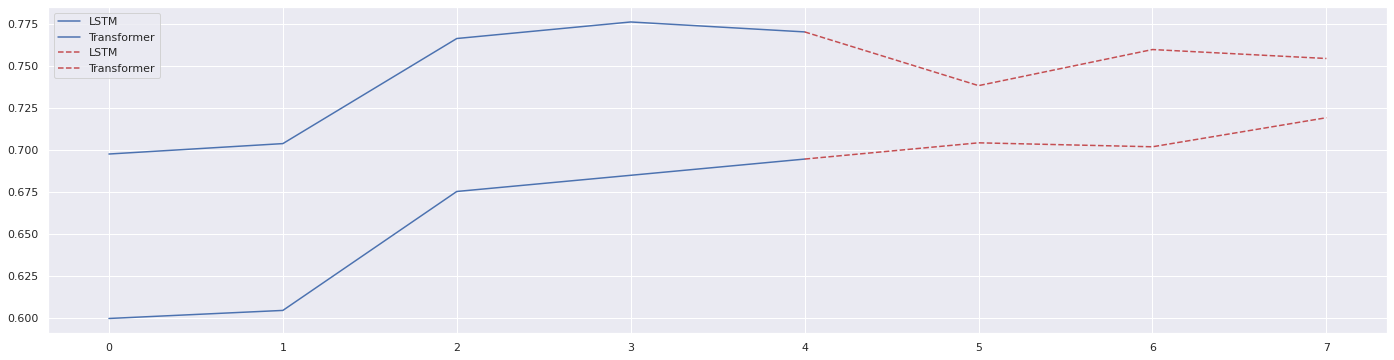

In [ ]:
# Forecast performance?

LSTM_forecast = [%alias]
Transformer_forecast = []


# df = pd.DataFrame({"LSTM" : LSTM_datasize + LSTM_forecast , "Transformer": Transformer_datasize + Transformer_forecast})

# ax = df.iloc[:8,:].plot(ls="-", color="b")
# df.iloc[7:,:].plot(ls="--", color="r", ax=ax)

# plt.show()